In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

### Settings
Define an output folder containing saved results from run_ensemble.py

In [2]:
ensemble_model_output_folder = 'ensemble_inter_dev'

agreement_metrics = [['Lime_agreement'],
                     ['Shap_agreement'],
                     ['Attention_agreement'],
                     ['Integrated_Grad_agreement'],
                     ['Lime_agreement', 'Integrated_Grad_agreement'],
                     ['Lime_agreement', 'Shap_agreement', 'Attention_agreement', 'Integrated_Grad_agreement']
                    ]

### Generate performance metrics
(will calculate interpretability weighted ensemble predictions for each item in agreement_metrics)

In [3]:
#df = pd.read_csv(f'../results/{ensemble_model_output_folder}/all_constituent_predictions_ensemble_model.csv')
df = pd.read_pickle(f'../results/{ensemble_model_output_folder}/all_constituent_predictions_ensemble_model.pkl')
#df.head(2)

In [5]:
### individual model predictions ###
models = sorted(list(set(df['Model_id'].values)))

all_ensemble_preds = df[df['Model_id'] == models[0]][['Test_example', 'True Label', 'Tokens_unified']]

for m in models:
    all_ensemble_preds[m] = df[df['Model_id'] == m]['Probability for Hate'].values

### majority vote baseline ###
all_ensemble_preds['majority_baseline'] = all_ensemble_preds[models].median(axis=1)

### straight avg baseline ###
all_ensemble_preds['straight_avg_baseline'] = all_ensemble_preds[models].mean(axis=1)


### interpretability weighted predictions ###

# Define a lambda function to compute the weighted mean:
wm = lambda x: np.average(x, weights=temp.loc[x.index, "agreement"])

for mt in agreement_metrics:
    
    temp = df[['Test_example', 'Model_id', 'Probability for Hate']].copy()
    temp['agreement'] = df[mt].mean(axis=1)
    modal_vote = temp.loc[temp.groupby("Test_example")["agreement"].idxmax()]['Probability for Hate'].values
    wtd_vote = temp.groupby(["Test_example"]).agg(wtd_vote=("Probability for Hate", wm)).wtd_vote.values
    all_ensemble_preds[f"{'_'.join(mt)}_model_vote"] = modal_vote
    all_ensemble_preds[f"{'_'.join(mt)}_wtd_avg"] = wtd_vote

In [6]:
# Calculate and save ensemble metrics
precisions = []
recalls = []
f1_scores = []
accuracies = []

for ensemble_pred in all_ensemble_preds.columns[3:]:
        y_true = np.array(all_ensemble_preds['True Label'])
        y_pred = np.array(all_ensemble_preds[ensemble_pred] >= 0.5)
        tp, fn, fp, tn = confusion_matrix(y_true, y_pred, labels=[1,0]).ravel()
        precisions.append(tp / (tp + fp))
        recalls.append(tp / (tp + fn))
        f1_scores.append(2 * tp / (2*tp + fp + fn))
        accuracies.append((tp + tn) / (tp + tn + fp + fn))

metrics = pd.DataFrame({'model': all_ensemble_preds.columns[3:],
                        'precision': precisions,
                        'recall': recalls,
                        'f1_score': f1_scores,
                        'accuracy': accuracies})
metrics

,model,precision,recall,f1_score,accuracy
0,bert_medium_rand_1,0.780303,0.858333,0.817460,0.807531
1,bert_medium_rand_2,0.751773,0.883333,0.812261,0.794979
2,bert_medium_rand_3,0.781955,0.866667,0.822134,0.811715
3,bert_rand_1,0.846154,0.825000,0.835443,0.836820
4,bert_rand_2,0.830508,0.816667,0.823529,0.824268
5,bert_rand_3,0.809524,0.850000,0.829268,0.824268
6,roberta_rand_1,0.760000,0.791667,0.775510,0.769874
7,roberta_rand_2,0.810811,0.750000,0.779221,0.786611
8,roberta_rand_3,0.774194,0.800000,0.786885,0.782427
9,majority_baseline,0.807692,0.875000,0.840000,0.832636


### Quick plot to see what the average agreement (and spread) is across test examples

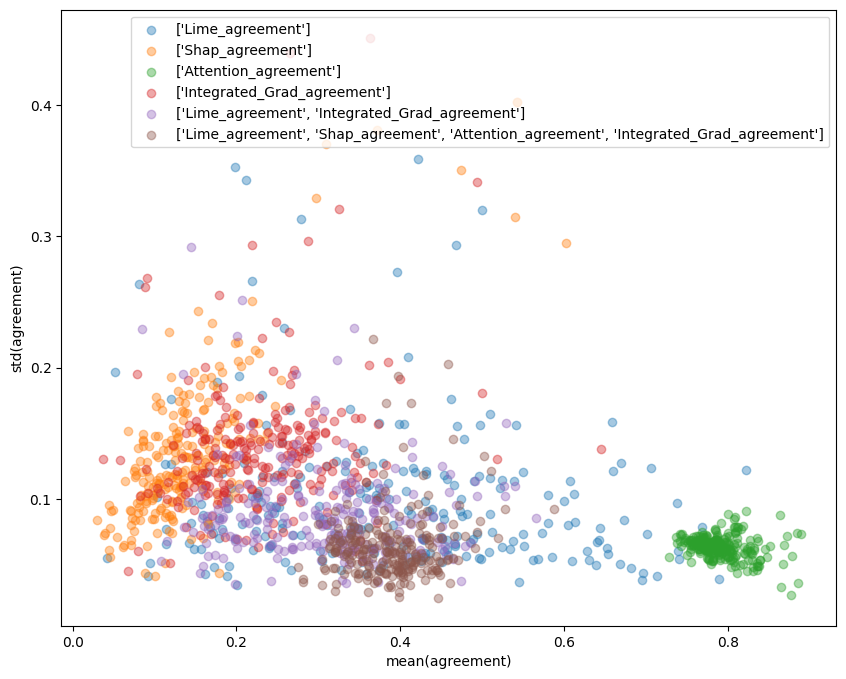

In [9]:
plt.figure(figsize=(10,8))
for mt in agreement_metrics:
    temp = df[['Test_example']].copy()
    temp['agreement'] = df[mt].mean(axis=1)
     
    stds = temp.groupby('Test_example')['agreement'].std()
    means = temp.groupby('Test_example')['agreement'].mean()

    plt.scatter(x = means, y = stds, label = mt, alpha = 0.4)
    plt.xlabel('mean(agreement)')
    plt.ylabel('std(agreement)')
    plt.legend()